## Notebook that generates figures for jerks paper

In [7]:
import sys
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings


import os.path
import chaosmagpy as cp


model_CHAOS718 = cp.load_CHAOS_matfile('../Geomagnetic_field_models/CHAOS-7.18.mat')  # load model
model_CHAOS82 = cp.load_CHAOS_matfile('../Geomagnetic_field_models/CHAOS-8.2.mat')  # load model
 
import cdflib # For reading cdf data files
import cartopy.crs as ccrs # Cartopy is used for projections of world map 
import cartopy as Cartopy # Cartopy is used for projections of world map 


import pickle
dir = '../ensemble_diagnostics/'
Nsample = 1  #1M samples
filename = dir+"/Jerks_CHAOS718_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS718 = pickle.load(fp)
    

Nsample = 1  #1M samples
filename = dir+"/Jerks_CHAOS82_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82 = pickle.load(fp)





jerk_threshold = np.array([12,20,25])
jerk_tolerance = 0.5 # this is the tolerance we allow when plotting jerks at the "same time".

In [8]:
# Count the number of jerks overall:

num = 0
for jerk in results_CHAOS82:
    
    for component in [0,1,2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        num += len(jerk[offset])
print('Total number of jerks is ', num)

Total number of jerks is  26288


In [9]:
# Number of locations:
print("Total number of locations ", phis.shape[0] * thetas.shape[0] )

Total number of locations  2376


## Figure 1

Theta, phi are  90.0 0.0
Theta, phi are  90.0 -160.0


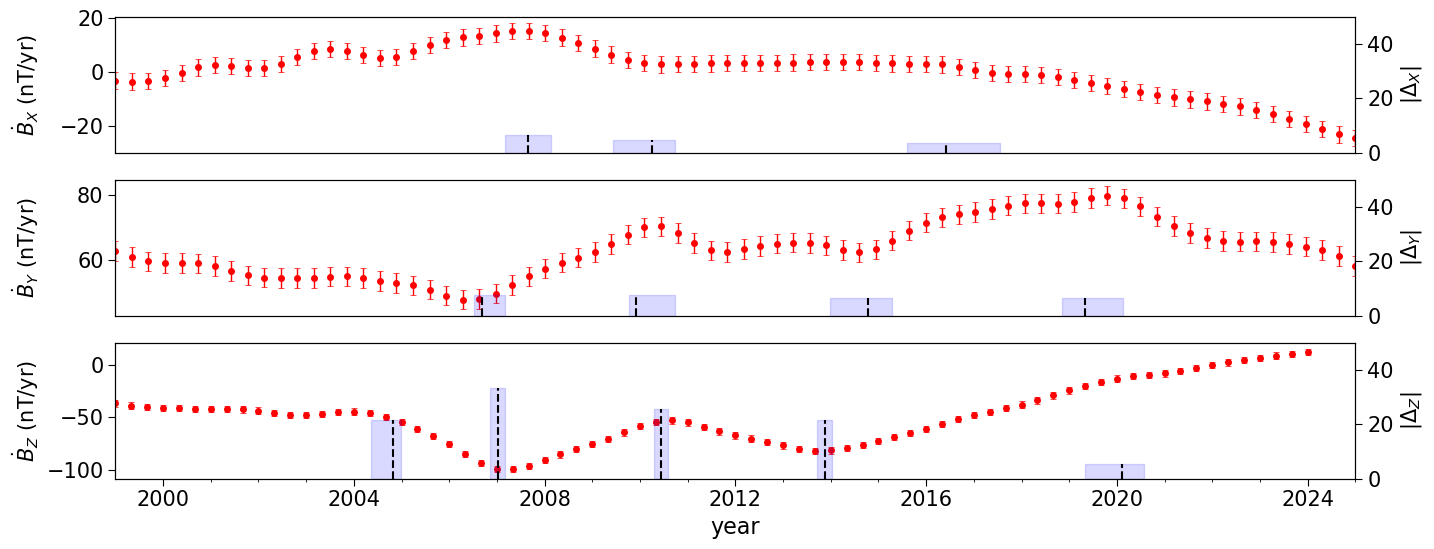

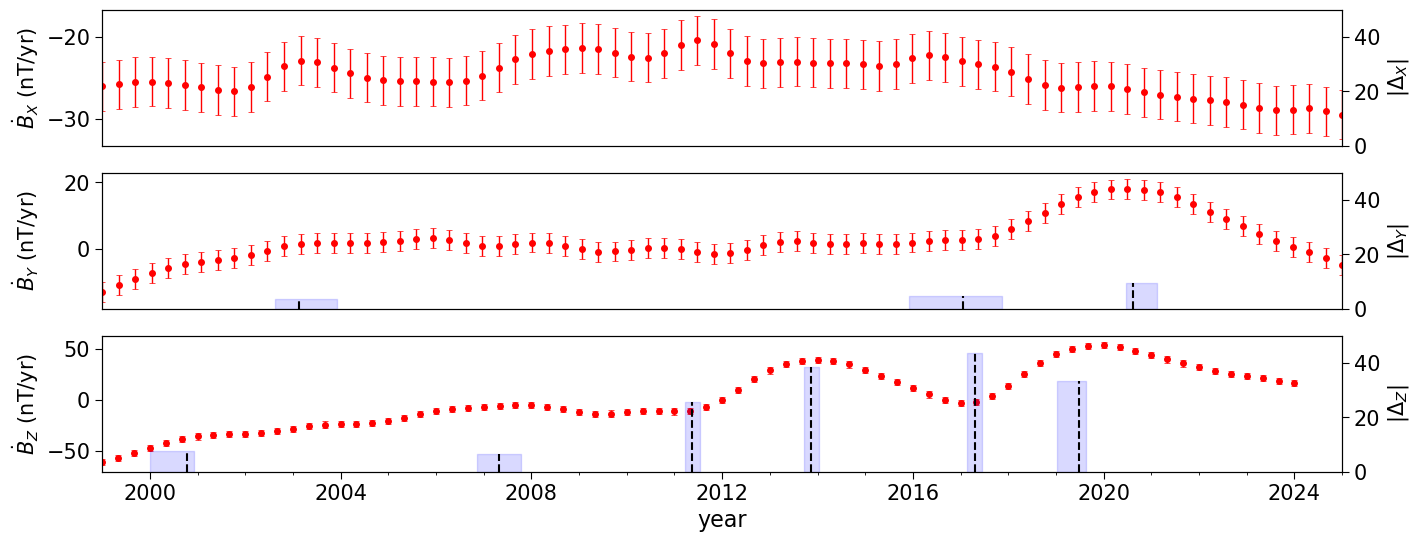

In [10]:
for theta_loc, phi_loc,filename in [[90,0,'fig1a.pdf'],[90, -160,'fig1b.pdf']]:


    fig, ax = plt.subplots( 3,1,  sharex='row',figsize=(16,6))   
    
    # SV from CHAOS 8.1
    radius = 6371.
    time_CHAOS = np.arange(1999,2024.1,1/3.0)
    mjd = cp.data_utils.dyear_to_mjd(time_CHAOS, leap_year=False)
    
    # find nearest grid point:
    dist2 = np.zeros(thetas.shape[0] * phis.shape[0])
    for i in range(thetas.shape[0] * phis.shape[0]):
        dist2[i] = (results_CHAOS82[i][0] - theta_loc)**2 + \
                  (results_CHAOS82[i][1] - phi_loc)**2
    index_CHAOS82 = dist2.argmin()
    theta_CHAOS, phi_CHAOS = results_CHAOS82[index_CHAOS82][0], results_CHAOS82[index_CHAOS82][1]
    
    print('Theta, phi are ', theta_CHAOS, phi_CHAOS)
    dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, theta_CHAOS, phi_CHAOS, nmax=13, deriv=1)
    Bx_dot, By_dot, Bz_dot = -dBt, dBp, -dBr
    
    # plot SV
    for row in [0,1,2]:
        
        if row == 0:
            SV_plot = Bx_dot #x-component
            lab = r'dB_X/dt (nT/yr)'
        elif row == 1:
            SV_plot = By_dot  #y-component
            lab = r'dB_Y/dt (nT/yr)'
        elif row == 2:
            SV_plot = Bz_dot  #Z-component
            lab = r'dB_Z/dt (nT/yr)'
        ax[row].errorbar(time_CHAOS,SV_plot,yerr = 3, fmt='o', ms=4,
        color='red', capthick=0.5, elinewidth=1, capsize=2, label=lab )
    
    # plot jerks
    jerk = results_CHAOS82[index_CHAOS82]
    
    for row in [0,1,2]:
        if row == 0:
            offset = 3
        elif row == 1:
            offset = 7
        else:
            offset = 11
                    
        ymin = 0
        twinax = ax[row].twinx()
        
        if jerk[offset]:
            ymax = max(event[1] for event in jerk[offset])
            for event in jerk[offset]:
                twinax.vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                twinax.fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.15, color='blue')
        twinax.set_ylim([0,50])
        
        twinax.tick_params(axis='both', which='major', labelsize=15, length=5)
        if row == 0:
            twinax.set_ylabel(r'$\vert \Delta_X\vert $', fontsize=15)
            ax[row].set_ylabel(r'$\dot{B}_X$ (nT/yr)', fontsize=15)
        if row == 1:
            twinax.set_ylabel(r'$\vert \Delta_Y\vert $', fontsize=15)
            ax[row].set_ylabel(r'$\dot{B}_Y$ (nT/yr)', fontsize=15)
        if row == 2:
            twinax.set_ylabel(r'$\vert \Delta_Z\vert $', fontsize=15)
            ax[row].set_ylabel(r'$\dot{B}_Z$ (nT/yr)', fontsize=15)
    
                #ax[row].set_ylabel(r'nT/yr',fontsize=16)
    
        ax[row].set_xlim([1999,2024])
    
    for i in range(2):
        ax[i].set_xticks([])
        ax[i].tick_params(axis='both', which='major', labelsize=15, length=5)
        
    i=2
    ax[i].set_xticks(np.arange(2000,2024+2,4))
    ax[i].set_xticks(np.arange(2000,2024+2,1),minor=True)
    ax[i].tick_params(axis='both', which='major', labelsize=15, length=5)
    ax[i].set_xlabel('year',fontsize=16)
    #ax[i].set_ylabel(r'nT/yr',fontsize=16)
    
    #align y-labels
    fig.align_ylabels(ax[:])
    plt.savefig(filename, bbox_inches='tight')

# Figure 2

In [11]:
X_jerks = np.array([])
Y_jerks = np.array([])
Z_jerks = np.array([])
for jerk in results_CHAOS82:
    for comp in [0,1,2]:
        if comp == 0:
            offset = 3
        elif comp == 1:
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            if comp == 0:
                X_jerks = np.append(X_jerks,event[0])
            elif comp == 1:
                Y_jerks = np.append(Y_jerks,event[0])
            else:
                Z_jerks = np.append(Z_jerks,event[0])

In [12]:
X_jerks.shape[0], Y_jerks.shape[0], Z_jerks.shape[0], X_jerks.shape[0] + Y_jerks.shape[0] + Z_jerks.shape[0]

(7698, 7906, 10684, 26288)

From CHAOS8.2, Z component, jerks at times : [2002 2005 2008 2011 2014 2017 2020 2023]


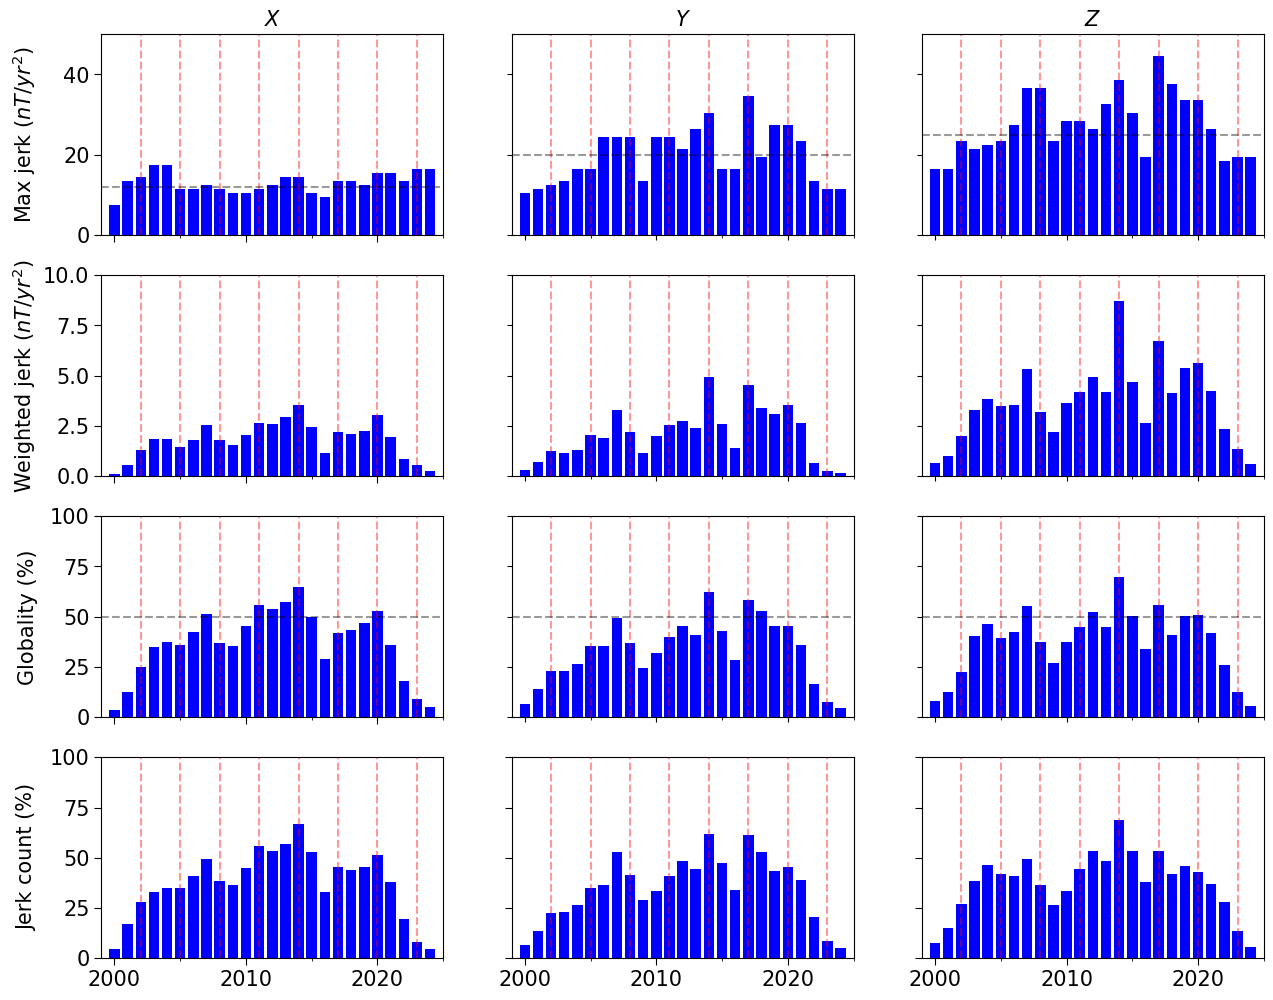

In [13]:
## Plot jerk amplitude as function of time, both by count, max, area - weighted and globality
import numpy as np

time_array = np.linspace(1999,2025,(2025 - 1999)+1)
data = np.zeros((time_array.shape[0],3, thetas.shape[0], phis.shape[0]) )  #this is the maximum value of jerk amplitude within a time bin, for a specific component, at (theta,phi).

for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [0,1,2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,component,theta_index,phi_index]):
                    data[itime,component,theta_index,phi_index] = abs(event[1]) 
                
# if (event[2] < time) and (event[3] > time) and (abs(event[1]) > data[itime,component,theta_index,phi_index]):
#                    data[itime,component,theta_index,phi_index] = abs(event[1]) 
                
fig,ax = plt.subplots(4,3,figsize=(15,12),sharex='col', sharey='row')

#  Maximum value

data_maxvalue = data.max(axis=3).max(axis=2)  #Take max over theta, phi.

bar_list = []
for i in [0,1,2]:
    ax[0,i].bar(time_array,data_maxvalue[:,i],color='blue')


# count

#ax[3,0].hist(X_jerks,bins=np.arange(1999.5,2026),density=True, color='b')
#ax[3,1].hist(Y_jerks,bins=np.arange(1999.5,2026),density=True, color='b')
#ax[3,2].hist(Z_jerks,bins=np.arange(1999.5,2026),density=True, color='b')


# check
'''    for iphi in range(phis.shape[0]):
    for itheta in range(thetas.shape[0]):
        if thetas[itheta] >= 90:
            data[:,:,itheta,iphi] = 10
        else:
            data[:,:,itheta,iphi] = 0
'''

# area-weighted
phi_difference = 5
weights = np.zeros((thetas.shape[0],phis.shape[0]))
for iphi in range(phis.shape[0]):
    for itheta in range(thetas.shape[0]):
        upper_theta = thetas[itheta] - 2.5
        lower_theta = thetas[itheta] + 2.5
        weights[itheta,iphi] = np.pi * abs(np.cos(upper_theta*np.pi/180) - np.cos(lower_theta*np.pi/180)) * phi_difference/180.0
#for event_index, event_time in enumerate(midpoint_times):
# np.sum(weights) = 12.45886
# 4 pi = 12.5663
# so it approximates the analytic expression for the surface integral of 1.
normalise_factor = np.pi * 4

data_weighted = np.zeros((data.shape[0], data.shape[1]))
for itime in range(len(time_array)):
    for component in range(3):
        data_weighted[itime,component] = (data[itime, component, :,:] * weights).flatten().sum()

data_weighted = data_weighted / normalise_factor    

for i in [0,1,2]:
    ax[1,i].bar(time_array,data_weighted[:,i],color='blue')


# globality of jerks
data_globality = np.zeros((data.shape[0], data.shape[1]))
for itime in range(len(time_array)):
    for component in range(3):
        for itheta in range(thetas.shape[0]):
            for iphi in range(phis.shape[0]):
                if data[itime, component, itheta, iphi] != 0.0:
                    data_globality[itime,component] += weights[itheta,iphi]
                    
data_globality = data_globality / normalise_factor  * 100

for i in [0,1,2]:
    ax[2,i].bar(time_array,data_globality[:,i],color='blue')


# count of jerks
data_globality = np.zeros((data.shape[0], data.shape[1]))
for itime in range(len(time_array)):
    for component in range(3):
        for itheta in range(thetas.shape[0]):
            for iphi in range(phis.shape[0]):
                if data[itime, component, itheta, iphi] != 0.0:
                    data_globality[itime,component] += 1
                    
for i in [0,1,2]:
    data_globality[:,i] = data_globality[:,i] / (thetas.shape[0] * phis.shape[0]) * 100
    ax[3,i].bar(time_array,data_globality[:,i], color='blue')

#from scipy.signal import find_peaks
#CHAOS_Z_times, CHAOS_Z_jerks = time_array,data_maxvalue[:,2]
#peaks, props = find_peaks(CHAOS_Z_jerks,distance=6, plateau_size = (None, None)) # 2yr = 6 widths of 4 months apart
#approx_jerk_peaks_max =  np.round(CHAOS_Z_times[peaks])
#approx_jerk_peaks_max = [int(a) for a in approx_jerk_peaks_max] #convert to integer.

#approx_jerk_peaks_max = np.zeros( len(peaks))
#for i, left_index in enumerate(props['left_edges']):
#    right_index = props['right_edges'][i]
#    mid = int(np.round( (left_index + right_index)/2.0))  #report the index closest to the middle of the plateau that defines each peak.
#    approx_jerk_peaks_max[i] = int(np.round(CHAOS_Z_times[mid]))
#

approx_jerk_peaks_max = np.arange(2002,2025,3)

for jerk_time in approx_jerk_peaks_max:
    for i in [0,1,2]:
        ax[0,i].vlines(jerk_time, 0,70, colors='red',alpha=0.4,linestyles='dashed')
        ax[1,i].vlines(jerk_time, 0,50, colors='red',alpha=0.4,linestyles='dashed')
        ax[2,i].vlines(jerk_time, 0,100, colors='red',alpha=0.4,linestyles='dashed')
        ax[3,i].vlines(jerk_time, 0,100, colors='red',alpha=0.4,linestyles='dashed')

for i in [0,1,2]:
    ax[0,i].hlines(jerk_threshold[i],1999, 2025, colors='black',alpha=0.4,linestyles='dashed')

# globality
for i in [0,1,2]:
    ax[2,i].hlines(50,1999, 2025, colors='black',alpha=0.4,linestyles='dashed')

for i in range(3):
    ax[3,i].set_xlim(1999,2024)
    ax[3,i].set_xticks([2000,2010,2020])
    ax[3,i].set_xticks([2005,2015,2025],minor=True)
    ax[3,i].tick_params(axis='both', which='major', labelsize=15, length=5)
    
ax[0,0].set_ylim(0,50)   
ax[1,0].set_ylim(0,10)
ax[2,0].set_ylim(0,100)
ax[3,0].set_ylim(0,100)

#ax[0,0].set_yticks([0,10,20,30,40,50,60,70])
#ax[2,0].set_yticks([0,10,20,30,40,50])

ax[2,0].tick_params(axis='both', which='major', labelsize=15, length=5)
ax[3,0].tick_params(axis='both', which='major', labelsize=15, length=5)
ax[1,0].tick_params(axis='both', which='major', labelsize=15, length=5)
ax[0,0].tick_params(axis='both', which='major', labelsize=15, length=5)
ax[3,1].tick_params(axis='both', which='major', labelsize=15, length=5)
ax[3,2].tick_params(axis='both', which='major', labelsize=15, length=5)

ax[0,0].set_title(r'$X$', fontsize=15)
ax[0,1].set_title(r'$Y$', fontsize=15)
ax[0,2].set_title(r'$Z$', fontsize=15)
ax[0,0].set_ylabel(r'Max jerk ($nT/yr^2$)',fontsize=15)
ax[1,0].set_ylabel(r'Weighted jerk ($nT/yr^2$)',fontsize=15)
ax[2,0].set_ylabel(r'Globality (%)',fontsize=15)
ax[3,0].set_ylabel(r'Jerk count (%)',fontsize=15)

fig.align_ylabels(ax[:,0])

fig.savefig('fig2.pdf', bbox_inches='tight')
print('From CHAOS8.2, Z component, jerks at times :', approx_jerk_peaks_max)


In [15]:
def plot_map_within_uncertainty(time_min, time_max, thetas, phis, jerks, component = 2, max_scale=40, save_name=False, max_Delta = 100, min_Delta = 0, axes = None, show_colour_bar = True, title=False, signed=None, globality=True):
    ''' Plot a map of the jerks whose timing is consistent with the given time.
    
    Inputs:
    time_min, time_max:  the time period at which to plot
    component: 0,1,2 (for Bx, By, Bz) respectively
    max_scale: the maximum scale
    jerks: a list of jerk information
    save_name: False, or the name of the file for saving
    max_Delta: the maximum amplitude to qualify for a jerk. Setting this to a low number removes strong events.
    min_Delta: the minimum amplitude to qualify for a jerk. Setting this to a high number removes weak events.
    ax: a set of axes to plot the figure
    signed: True if plot the signed value of Delta
    title: title of plot
    Outputs:
    
    Creates a plot of the maximum Delta 
    '''
    temporary_axes = False
    
    data = np.zeros(( phis.shape[0], thetas.shape[0]))
    for jerk in jerks:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        theta = jerk[0]
        phi=jerk[1]
        
        theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
        data[phi_index,theta_index] = 0
        for event in jerk[offset]:
# check to see if the jerk window agrees has any overlap with the time period. Easiest to check if there is NOT no overlap.
# No overlap occurs if either the jerk window comes after the period, or before.
            
            if not ( (event[3] < time_min) or (event[2] > time_max)) and (abs(event[1]) < max_Delta) \
            and (abs(event[1]) > min_Delta):
                if not signed:
                    data[phi_index,theta_index] = max(data[phi_index,theta_index],abs(event[1] ))
                else:
                    if abs(event[1]) > abs(data[phi_index,theta_index]):
                           data[phi_index,theta_index] = event[1]
                    
    if axes == None:
        f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
        temporary_axes = True
    
    marker_size = 11. 

    import matplotlib.cm as cm
    
    
    #cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
    #axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
    if not signed:
        my_cmap = plt.get_cmap("Reds").copy()
        my_cmap.set_under('w')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=1, vmax=max_scale, transform=ccrs.PlateCarree())
    else:
        my_cmap = plt.get_cmap('bwr')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=-max_scale, vmax=max_scale, transform=ccrs.PlateCarree())

    #gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
    #              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    
    axes.coastlines()
    
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    
    if show_colour_bar:
        clb = plt.colorbar(pc, ax=axes, shrink=0.3)
        clb.set_label(r'$\Delta (nT/yr^2$)', fontsize=20)
        clb.ax.tick_params(labelsize=20)


    if globality:
        data_binary = np.zeros(data.shape)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] != 0:
                    data_binary[i,j] = 1.0
                    
        phi_difference = 5
        weights = np.zeros((phis.shape[0],thetas.shape[0]))
        for iphi in range(phis.shape[0]):
            for itheta in range(thetas.shape[0]):
                upper_theta = thetas[itheta] - 2.5
                lower_theta = thetas[itheta] + 2.5
                weights[iphi, itheta] = np.pi * abs(np.cos(upper_theta*np.pi/180) - np.cos(lower_theta*np.pi/180)) * phi_difference/180.0
        global_frac = (weights * data_binary).flatten().sum() / weights.flatten().sum() * 100
        plt.annotate('Globality {0:2.0f}%'.format(np.round(global_frac)), xy=(0.1, -0.1), xycoords='axes fraction', fontsize=20, ha='center')
    
    if title != False:
        axes.set_title(title, fontsize=30)
        
    if save_name != False:
        plt.savefig(save_name, bbox_inches='tight')

    if temporary_axes:
        plt.close()

In [16]:
def plot_map_within_uncertainty_ortho(time_min, time_max, thetas, phis, jerks, component = 2, max_scale=40, save_name=False, max_Delta = 100, min_Delta = 0, axes = None, show_colour_bar = True, title=False, signed=None, centrepoint=(0,0)):
    ''' Plot a map of the jerks whose timing is consistent with the given time.
    
    Inputs:
    time_min, time_max:  the time period at which to plot
    component: 0,1,2 (for Bx, By, Bz) respectively
    max_scale: the maximum scale
    jerks: a list of jerk information
    save_name: False, or the name of the file for saving
    max_Delta: the maximum amplitude to qualify for a jerk. Setting this to a low number removes strong events.
    min_Delta: the minimum amplitude to qualify for a jerk. Setting this to a high number removes weak events.
    ax: a set of axes to plot the figure
    signed: True if plot the signed value of Delta
    title: title of plot
    centrepoint = (lat,long): the centre point of the projection
    Outputs:
    
    Creates a plot of the maximum Delta 
    '''
    temporary_axes = False
    
    data = np.zeros(( phis.shape[0], thetas.shape[0]))
    for jerk in jerks:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        theta = jerk[0]
        phi=jerk[1]
        
        theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
        data[phi_index,theta_index] = 0
        for event in jerk[offset]:
# check to see if the jerk window agrees has any overlap with the time period. Easiest to check if there is NOT no overlap.
# No overlap occurs if either the jerk window comes after the period, or before.
            
            if not ( (event[3] < time_min) or (event[2] > time_max)) and (abs(event[1]) < max_Delta) \
            and (abs(event[1]) > min_Delta):
                if not signed:
                    data[phi_index,theta_index] = max(data[phi_index,theta_index],abs(event[1] ))
                else:
                    if abs(event[1]) > abs(data[phi_index,theta_index]):
                           data[phi_index,theta_index] = event[1]
                    
    if axes == None:
        f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Orthographic(central_longitude=centrepoint[1], central_latitude=centrepoint[0]) }) 
        temporary_axes = True
    
    marker_size = 11. 

    import matplotlib.cm as cm
    
    
    #cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
    #axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
    if not signed:
        my_cmap = plt.get_cmap("Reds").copy()
        my_cmap.set_under('w')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=1, vmax=max_scale, transform=ccrs.PlateCarree())
    else:
        my_cmap = plt.get_cmap('bwr')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=-max_scale, vmax=max_scale, transform=ccrs.PlateCarree())

    #gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
    #              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    
    axes.coastlines()
    
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    
    if show_colour_bar:
        clb = plt.colorbar(pc, ax=axes, shrink=0.3)
        clb.set_label(r'$\Delta (nT/yr^2$)', fontsize=20)
        clb.ax.tick_params(labelsize=20)

    if title != False:
        axes.set_title(title, fontsize=30)
        
    if save_name != False:
        plt.savefig(save_name, bbox_inches='tight')

    if temporary_axes:
        plt.close()

In [17]:
def plot_map(time_min, time_max, thetas, phis, jerks, component = 2, max_scale=40, save_name=False, max_Delta = 100, min_Delta = 0, axes = None, show_colour_bar = True, title=False, signed=None, globality=True):
    ''' Plot a map of the jerks that occured in a given time interval
    
    Inputs:
    time_min, time_max:  the time window over which to plot
    component: 0,1,2 (for Bx, By, Bz) respectively
    max_scale: the maximum scale
    jerks: a list of jerk information
    save_name: False, or the name of the file for saving
    max_Delta: the maximum amplitude to qualify for a jerk. Setting this to a low number removes strong events.
    min_Delta: the minimum amplitude to qualify for a jerk. Setting this to a high number removes weak events.
    ax: a set of axes to plot the figure
    signed: True if plot the signed value of Delta
    title: title of plot
    Outputs:
    
    Creates a plot of the maximum Delta within [time_min, time_max].
    Optionally, for each location, these values are scaled by the range (max-min) SV over the window [norm_start_time, norm_end_time] 
    '''
    temporary_axes = False
    
    data = np.zeros(( phis.shape[0], thetas.shape[0]))
    for jerk in jerks:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        theta = jerk[0]
        phi=jerk[1]
        
        theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
        data[phi_index,theta_index] = 0
        for event in jerk[offset]:
            if (event[0] > time_min) and (event[0] < time_max) and (abs(event[1]) < max_Delta) \
            and (abs(event[1]) > min_Delta):
                if not signed:
                    data[phi_index,theta_index] = max(data[phi_index,theta_index],abs(event[1] ))
                else:
                    if abs(event[1]) > abs(data[phi_index,theta_index]):
                           data[phi_index,theta_index] = event[1]
                    
    if axes == None:
        f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
        temporary_axes = True
    
    marker_size = 11. 

    import matplotlib.cm as cm

    
    #cax = axes.scatter(phi_grid,90.-theta_grid, s = marker_size, c=slopes[:,:,time_index],cmap=cmap, vmin=0, vmax=10)
    #axes.pcolormesh(slopes[:,:,time_index],origin='upper',extent=(-180,180,90,0) )
    if not signed:
        my_cmap = plt.get_cmap("Reds").copy()
        my_cmap.set_under('w')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=1, vmax=max_scale, transform=ccrs.PlateCarree())
    else:
        my_cmap = plt.get_cmap('bwr')
        pc = axes.pcolormesh(phis, 90. - thetas, data.T, cmap=my_cmap,vmin=-max_scale, vmax=max_scale, transform=ccrs.PlateCarree())

    #gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
    #              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    
    axes.coastlines()
    
    axes.top_labels = False
    axes.right_labels = False
    axes.xlines = False
    
    if show_colour_bar:
        clb = plt.colorbar(pc, ax=axes, shrink=0.3)
        clb.set_label(r'$\Delta (nT/yr^2$)', fontsize=20)
        clb.ax.tick_params(labelsize=20)


    if globality:
        data_binary = np.zeros(data.shape)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if data[i,j] != 0:
                    data_binary[i,j] = 1.0
                    
        phi_difference = 5
        weights = np.zeros((phis.shape[0],thetas.shape[0]))
        for iphi in range(phis.shape[0]):
            for itheta in range(thetas.shape[0]):
                upper_theta = thetas[itheta] - 2.5
                lower_theta = thetas[itheta] + 2.5
                weights[iphi, itheta] = np.pi * abs(np.cos(upper_theta*np.pi/180) - np.cos(lower_theta*np.pi/180)) * phi_difference/180.0
        global_frac = (weights * data_binary).flatten().sum() / weights.flatten().sum() * 100
        plt.annotate('Globality {0:2.0f}%'.format(np.round(global_frac)), xy=(0.1, 0), xycoords='axes fraction', fontsize=20, ha='center')
    
    if title != False:
        axes.set_title(title, fontsize=30)
        
    if save_name != False:
        plt.savefig(save_name, bbox_inches='tight')

    if temporary_axes:
        plt.close()

In [170]:
#plot_map_within_uncertainty(2014-1/2, 2014+1/2, thetas, phis, results_CHAOS82, component = 2, signed=True, 
#         max_scale=40, save_name = 'temp.pdf')

In [157]:
#plot_map_within_uncertainty_ortho(2014-1/2, 2014+1/2, thetas, phis, results_CHAOS82, component = 2, signed=True, 
#         max_scale=40, save_name = 'temp.pdf')

In [18]:
for k in approx_jerk_peaks_max:
    plot_map_within_uncertainty(k-jerk_tolerance, k+jerk_tolerance, thetas, phis, results_CHAOS82, component = 2, signed=True, 
         max_scale=40,title='Z component, {0:d}'.format(k), save_name='CHAOS_{0:d}_Z.pdf'.format(k))

In [19]:
for k in approx_jerk_peaks_max:
    plot_map_within_uncertainty(k-jerk_tolerance, k+jerk_tolerance, thetas, phis, results_CHAOS82, component = 1, signed=True, 
         max_scale=40,title='Y component, {0:d}'.format(k), save_name='CHAOS_{0:d}_Y.pdf'.format(k))
for k in approx_jerk_peaks_max:
    plot_map_within_uncertainty(k-jerk_tolerance, k+jerk_tolerance, thetas, phis, results_CHAOS82, component = 0, signed=True, 
         max_scale=40,title='X component, {0:d}'.format(k), save_name='CHAOS_{0:d}_X.pdf'.format(k))

In [27]:
for k in np.arange(2000,2025):
    plot_map_within_uncertainty(k-jerk_tolerance,k+jerk_tolerance, thetas, phis, results_CHAOS82, component = 2, signed=True, 
         max_scale=40,title='Z component, {0:d}'.format(k), save_name='Yearly_pattern_CHAOS82_{0:d}_Z.pdf'.format(k))

# Correlation

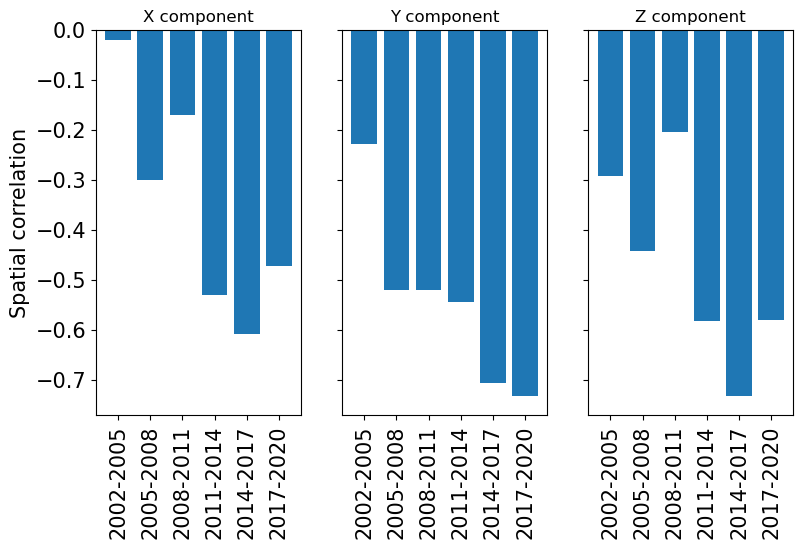

In [20]:
approx_jerk_peaks_reduced = approx_jerk_peaks_max[0:-1]

# calc covariance of subsequent peaks

phi_difference = 5
weights = np.zeros((phis.shape[0],thetas.shape[0]))
for iphi in range(phis.shape[0]):
    for itheta in range(thetas.shape[0]):
        upper_theta = thetas[itheta] - 2.5
        lower_theta = thetas[itheta] + 2.5
        weights[iphi, itheta] = np.pi * abs(np.cos(upper_theta*np.pi/180) - np.cos(lower_theta*np.pi/180)) * phi_difference/180.0
#for event_index, event_time in enumerate(midpoint_times):
# np.sum(weights) = 12.45886
# 4 pi = 12.5663
# so it approximates the analytic expression for the surface integral of 1.
normalise_factor = np.pi * 4

fig, ax = plt.subplots(1,3, figsize=(9,5), sharey = True )

for component in [0,1,2]:
    data_correlation = np.zeros(( phis.shape[0], thetas.shape[0],len(approx_jerk_peaks_reduced)))
    for ipeaks,peak in enumerate(approx_jerk_peaks_reduced[:]):
        
        for jerk in results_CHAOS82:
            if component == 0:
                offset = 3
            elif component == 1: 
                offset = 7
            else:
                offset = 11
            theta = jerk[0]
            phi=jerk[1]
    
            theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()
            for event in jerk[offset]:
                if not ( (event[3] < peak-0.5) or (event[2] > peak+0.5)):
                    if abs(event[1]) > abs(data_correlation[phi_index,theta_index,ipeaks]):
                               data_correlation[phi_index,theta_index,ipeaks] = event[1]
    
    
    correl = np.zeros(data_correlation.shape[2]-1)
    for i in range(data_correlation.shape[2]-1):
        correl[i] = np.sum(weights * data_correlation[:,:,i] * data_correlation[:,:,i+1])/ \
              ( np.sqrt(np.sum(weights * data_correlation[:,:,i]**2)) * 
              np.sqrt(np.sum(weights * data_correlation[:,:,i+1]**2))  )
    
    
    labels = []
    for ipeaks,peak in enumerate(approx_jerk_peaks_reduced[:-1]):
        labels += ['{0:4.0f}-{1:4.0f}'.
                   format(approx_jerk_peaks_reduced[ipeaks], 
                          approx_jerk_peaks_reduced[ipeaks+1])]
                                    
    ax[component].bar(labels, correl )
    ax[component].tick_params(axis='both', which='major', labelsize=15)
                  # setting label for x tick
    ax[component].set_xticks(np.arange(correl.shape[0]))
    ax[component].set_xticklabels(labels,rotation = 90)
    if component == 0:
        ax[component].set_title('X component' )
    elif component == 1:
        ax[component].set_title('Y component' )
    else:
        ax[component].set_title('Z component' )
ax[0].set_ylabel('Spatial correlation',fontsize=15)
    
fig.savefig('Correl.pdf', bbox_inches='tight')


# Weak/strong comparison

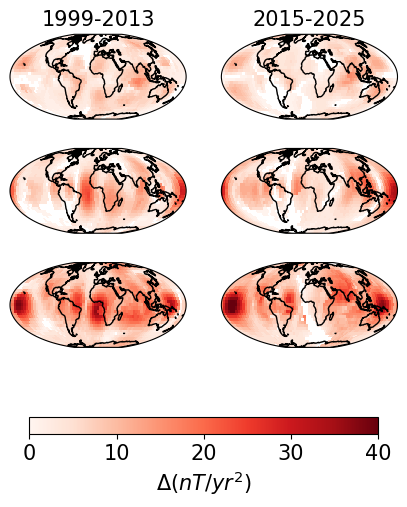

In [21]:
import matplotlib as mpl

f, axes = plt.subplots(nrows=3, ncols=2,figsize=(5,6), subplot_kw={'projection': ccrs.Mollweide() }) 
for i in range(3):
        plot_map(1999, 2014, thetas, phis, results_CHAOS82, show_colour_bar = False, axes = axes[i,0], component = i, max_scale=40, signed=False, globality=False)
        plot_map(2014, 2024, thetas, phis, results_CHAOS82, show_colour_bar = False, axes = axes[i,1], component = i, max_scale=40, signed=False, globality=False)

my_cmap = plt.get_cmap("Reds").copy()
norm = mpl.colors.Normalize(vmin=0,vmax=40)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])

cbar = f.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.9,orientation='horizontal')
cbar.set_ticks([0,10,20,30,40])


cbar.set_label(r'$\Delta (nT/yr^2$)', fontsize=15)
axes[0,0].set_title('1999-2013', fontsize=15)
axes[0,1].set_title('2015-2025', fontsize=15)
cbar.ax.tick_params(labelsize=15)

f.savefig('All_jerks_spatial.pdf', bbox_inches='tight')

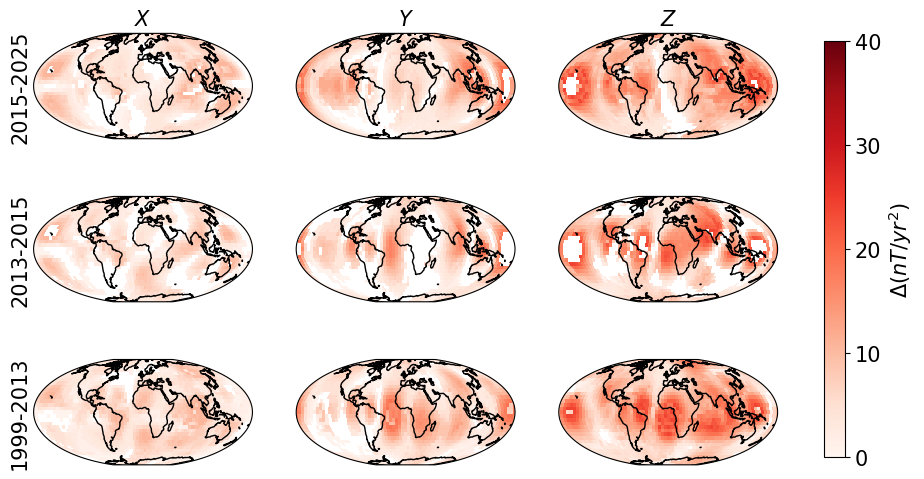

In [22]:
import matplotlib as mpl

f, axes = plt.subplots(nrows=3, ncols=3,figsize=(12,6), subplot_kw={'projection': ccrs.Mollweide() }) 
for i in range(3):
        plot_map_within_uncertainty(1999, 2013, thetas, phis, results_CHAOS82, show_colour_bar = False, max_Delta = jerk_threshold[i], axes = axes[2,i], component = i, max_scale=40, signed=False, globality=False)
        plot_map_within_uncertainty(2013, 2015, thetas, phis, results_CHAOS82, show_colour_bar = False, max_Delta = jerk_threshold[i], axes = axes[1,i], component = i, max_scale=40, signed=False, globality=False)
        plot_map_within_uncertainty(2015, 2025, thetas, phis, results_CHAOS82, show_colour_bar = False, max_Delta = jerk_threshold[i], axes = axes[0,i], component = i, max_scale=40, signed=False, globality=False)

my_cmap = plt.get_cmap("Reds").copy()
norm = mpl.colors.Normalize(vmin=0,vmax=40)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])

cbar = f.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.9,orientation='vertical')
cbar.set_ticks([0,10,20,30,40])

cbar.set_label(r'$\Delta (nT/yr^2$)', fontsize=15)

axes[0,0].set_title('$X$', fontsize=15)
axes[0,1].set_title('$Y$', fontsize=15)
axes[0,2].set_title('$Z$', fontsize=15)

axes[2,0].annotate('1999-2013', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)
axes[1,0].annotate('2013-2015', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)
axes[0,0].annotate('2015-2025', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)

#axes[1,0].set_title('2013.0-2015.0', fontsize=15)
#axes[2,0].set_title('2015.0-2025.0', fontsize=15)


cbar.ax.tick_params(labelsize=15)

f.savefig('Weak_jerks_spatial.pdf', bbox_inches='tight')

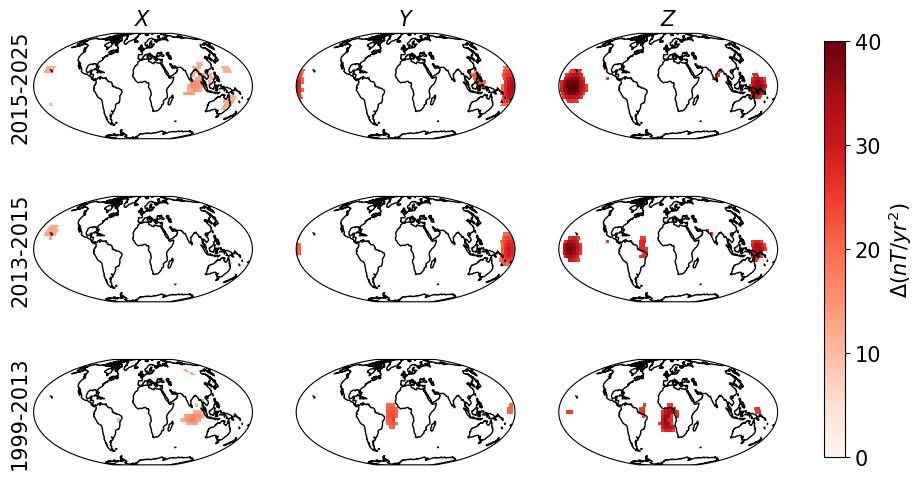

In [194]:
f, axes = plt.subplots(nrows=3, ncols=3,figsize=(12,6), subplot_kw={'projection': ccrs.Mollweide() }) 
for i in range(3):
        plot_map_within_uncertainty(1999, 2013, thetas, phis, results_CHAOS82, show_colour_bar = False, min_Delta = jerk_threshold[i], axes = axes[2,i], component = i, max_scale=40, signed=False,globality=False)
        plot_map_within_uncertainty(2013, 2015, thetas, phis, results_CHAOS82, show_colour_bar = False, min_Delta = jerk_threshold[i], axes = axes[1,i], component = i, max_scale=40, signed=False,globality=False)

        plot_map_within_uncertainty(2015, 2025, thetas, phis, results_CHAOS82, show_colour_bar = False, min_Delta = jerk_threshold[i], axes = axes[0,i], component = i, max_scale=40, signed=False,globality=False)
    
my_cmap = plt.get_cmap("Reds").copy()
norm = mpl.colors.Normalize(vmin=0,vmax=40)
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])

cbar = f.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.9,orientation='vertical')
cbar.set_ticks([0,10,20,30,40])
cbar.set_label(r'$\Delta (nT/yr^2$)', fontsize=15)

axes[0,0].set_title('$X$', fontsize=15)
axes[0,1].set_title('$Y$', fontsize=15)
axes[0,2].set_title('$Z$', fontsize=15)

axes[2,0].annotate('1999-2013', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)
axes[1,0].annotate('2013-2015', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)
axes[0,0].annotate('2015-2025', xy=(-17,0), xycoords='axes points', rotation=90, fontsize=15)

cbar.ax.tick_params(labelsize=15)
f.savefig('Strong_jerks_spatial.pdf', bbox_inches='tight')

In [241]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(1999, 2012, thetas, phis, results_CHAOS81, component = 2, max_scale=40, axes=axes, signed=False, save_name='CHAOS81_1999_2012_Z.pdf')

In [242]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(2012, 2024, thetas, phis, results_CHAOS81, component = 2, axes=axes, max_scale=40, signed=False, save_name='CHAOS81_2012_2024_Z.pdf')

In [243]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(2022, 2024, thetas, phis, results_CHAOS81, component = 2, axes=axes, max_scale=40, signed=False, save_name='CHAOS81_2022_2024_Z.pdf')

In [244]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(1999, 2012, thetas, phis, results_CHAOS81, component = 0, max_scale=40, axes=axes, signed=False, save_name='CHAOS81_1999_2012_X.pdf')

In [245]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(2012, 2024, thetas, phis, results_CHAOS81, component = 0, axes=axes, max_scale=40, signed=False, save_name='CHAOS81_2012_2024_X.pdf')

In [246]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(1999, 2012, thetas, phis, results_CHAOS81, component = 1, max_scale=40, axes=axes, signed=False, save_name='CHAOS81_1999_2012_Y.pdf')

In [247]:
#f, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,13), subplot_kw={'projection': ccrs.Mollweide() }) 
#plot_map(2012, 2024, thetas, phis, results_CHAOS81, component = 1, axes=axes, max_scale=40, signed=False, save_name='CHAOS81_2012_2024_Y.pdf')

##### time - longitude plot for CHAOS 8.2

<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/var/folders/c8/0lxh07f56ds0wttzd4_fnrmh0000gr/T/ipykernel_32685/1744442054.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('Longitude ($^\circ$)')


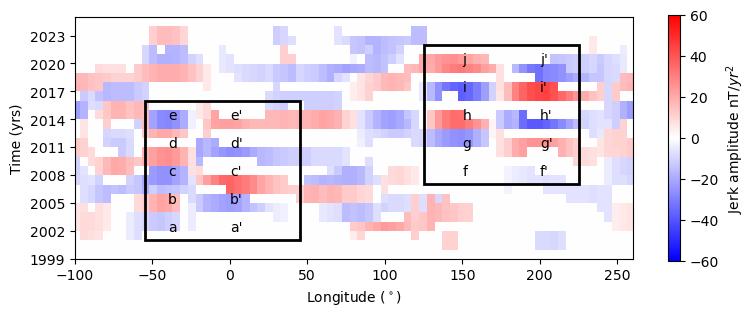

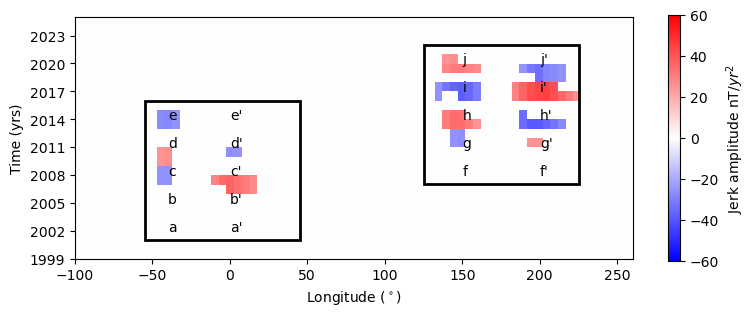

In [23]:
threshold = [0, jerk_threshold[2]]
time_array = np.linspace(2025,1999,26,endpoint=True)
longitude_array = phis 
component = 2
if component == 0:
    offset = 3
elif component == 1: 
    offset = 7
else:
    offset = 11

for thres in threshold:
    data = np.zeros((time_array.shape[0],longitude_array.shape[0]) )
    for jerk in results_CHAOS82:
        theta = jerk[0]
        phi=jerk[1]
        if phi < -360:
            phi += 360
        if phi > 360:
            phi -= 360
        index = abs(phis - phi).argmin()
    
        if abs(90-theta) < 10:
            for event in jerk[offset]:
                for itime, time in enumerate(time_array):
                   if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)):
                       if abs(event[1]) > abs(data[itime,index]) and abs(event[1]) > thres: 
                           data[itime,index] = event[1]
                       #data[itime,index] = time
    
    fig,ax = plt.subplots(1, figsize=(9,4) )
    extended_long = np.concatenate([phis[36:]-360,phis,phis[:37]+360])
    extended_data = np.concatenate([data[:,36:],data, data[:,:37]],axis=1)
    plt.imshow(extended_data, extent = (extended_long.min(), extended_long.max(), time_array.min(), time_array.max() ), cmap='bwr', aspect=6,vmin=-60,vmax=60)
    plt.colorbar(shrink = 0.8, label='Jerk amplitude nT$/yr^2$')
    
    ax.set_xlim(-100, 260)
    ax.set_yticks(np.arange(1999,2024,3))
    ax.set_xlabel('Longitude ($^\circ$)')
    ax.set_ylabel('Time (yrs)')
    import matplotlib.patches as patches
    rect = patches.Rectangle((-55, 2001), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    rect = patches.Rectangle((125, 2007), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    ax.annotate('e',xy=(-40,2014),color='k')
    ax.annotate('d',xy=(-40,2011),color='k')
    ax.annotate('c',xy=(-40,2008),color='k')
    ax.annotate('b',xy=(-40,2005),color='k')
    ax.annotate('a',xy=(-40,2002),color='k')
    
    ax.annotate("e'",xy=(0,2014),color='k')
    ax.annotate("d'",xy=(0,2011),color='k')
    ax.annotate("c'",xy=(0,2008),color='k')
    ax.annotate("b'",xy=(0,2005),color='k')
    ax.annotate("a'",xy=(0,2002),color='k')
    

    ax.annotate("f",xy=(150,2008))
    ax.annotate("g",xy=(150,2011))
    ax.annotate("h",xy=(150,2014))
    ax.annotate("i",xy=(150,2017))
    ax.annotate("j",xy=(150,2020))

    ax.annotate("f'",xy=(200,2008))
    ax.annotate("g'",xy=(200,2011))
    ax.annotate("h'",xy=(200,2014))
    ax.annotate("i'",xy=(200,2017))
    ax.annotate("j'",xy=(200,2020))
    
    fig.savefig('Time_long_threshold_Z_{0:d}.pdf'.format(thres),bbox_inches='tight')

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/c8/0lxh07f56ds0wttzd4_fnrmh0000gr/T/ipykernel_32685/882764133.py:40: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('Longitude ($^\circ$)')


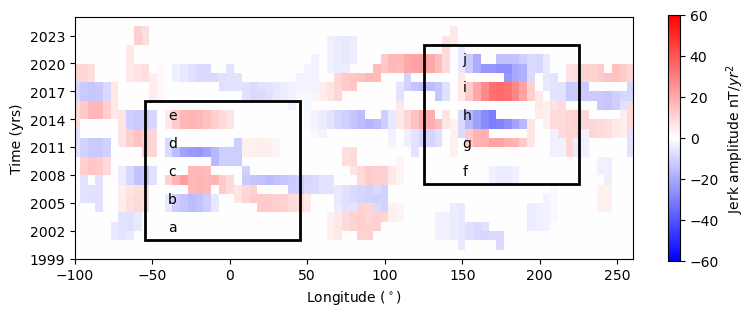

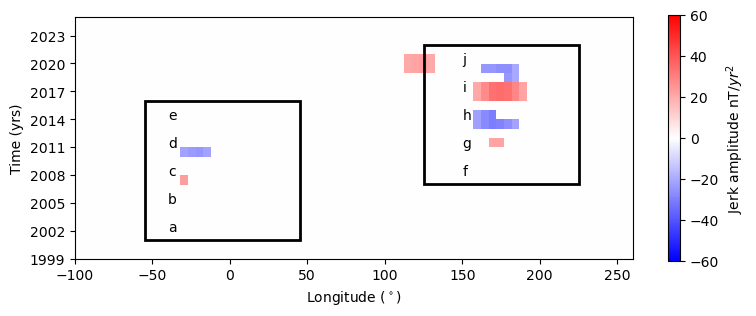

In [24]:
component = 1

threshold = [0, jerk_threshold[component]]
time_array = np.linspace(2025,1999,26,endpoint=True)
longitude_array = phis 
if component == 0:
    offset = 3
elif component == 1: 
    offset = 7
else:
    offset = 11

for thres in threshold:
    data = np.zeros((time_array.shape[0],longitude_array.shape[0]) )
    for jerk in results_CHAOS82:
        theta = jerk[0]
        phi=jerk[1]
        if phi < -360:
            phi += 360
        if phi > 360:
            phi -= 360
        index = abs(phis - phi).argmin()
    
        if abs(90-theta) < 10:
            for event in jerk[offset]:
                for itime, time in enumerate(time_array):
                   if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)):
                       if abs(event[1]) > abs(data[itime,index]) and abs(event[1]) > thres: 
                           data[itime,index] = event[1]
                       #data[itime,index] = time
    
    fig,ax = plt.subplots(1, figsize=(9,4) )
    extended_long = np.concatenate([phis[36:]-360,phis,phis[:37]+360])
    extended_data = np.concatenate([data[:,36:],data, data[:,:37]],axis=1)
    plt.imshow(extended_data, extent = (extended_long.min(), extended_long.max(), time_array.min(), time_array.max() ), cmap='bwr', aspect=6,vmin=-60,vmax=60)
    plt.colorbar(shrink = 0.8, label='Jerk amplitude nT$/yr^2$')
    
    ax.set_xlim(-100, 260)
    ax.set_yticks(np.arange(1999,2024,3))
    ax.set_xlabel('Longitude ($^\circ$)')
    ax.set_ylabel('Time (yrs)')
    import matplotlib.patches as patches
    rect = patches.Rectangle((-55, 2001), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    rect = patches.Rectangle((125, 2007), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    ax.annotate('e',xy=(-40,2014),color='k')
    ax.annotate('d',xy=(-40,2011),color='k')
    ax.annotate('c',xy=(-40,2008),color='k')
    ax.annotate('b',xy=(-40,2005),color='k')
    ax.annotate('a',xy=(-40,2002),color='k')
    

    ax.annotate("f",xy=(150,2008))
    ax.annotate("g",xy=(150,2011))
    ax.annotate("h",xy=(150,2014))
    ax.annotate("i",xy=(150,2017))
    ax.annotate("j",xy=(150,2020))


    fig.savefig('Time_long_threshold_Y_{0:d}.pdf'.format(thres),bbox_inches='tight')

<>:40: SyntaxWarning: invalid escape sequence '\c'
<>:40: SyntaxWarning: invalid escape sequence '\c'
/var/folders/c8/0lxh07f56ds0wttzd4_fnrmh0000gr/T/ipykernel_32685/1257644497.py:40: SyntaxWarning: invalid escape sequence '\c'
  ax.set_xlabel('Longitude ($^\circ$)')


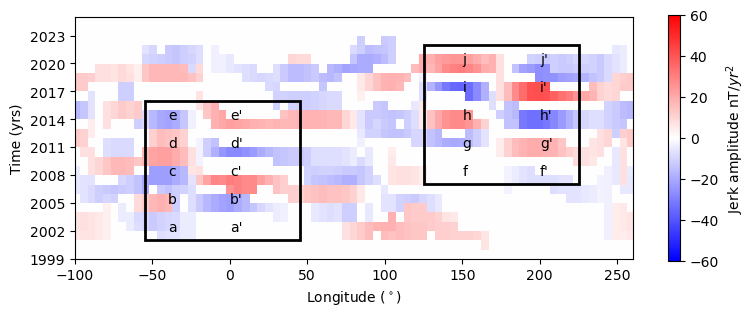

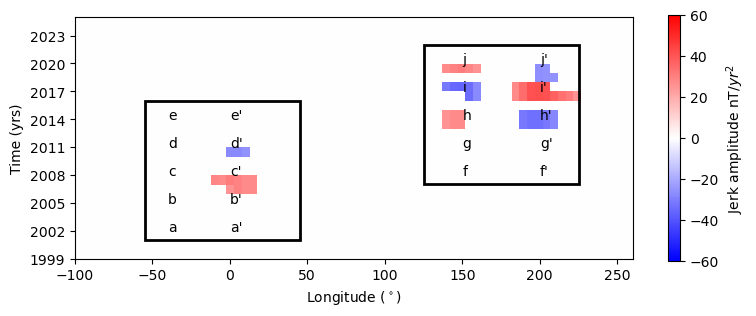

In [25]:
# TL for CHAOS07
threshold = [0, jerk_threshold[2]]
time_array = np.linspace(2025,1999,26,endpoint=True)
longitude_array = phis 
component = 2
if component == 0:
    offset = 3
elif component == 1: 
    offset = 7
else:
    offset = 11

for thres in threshold:
    data = np.zeros((time_array.shape[0],longitude_array.shape[0]) )
    for jerk in results_CHAOS718:
        theta = jerk[0]
        phi=jerk[1]
        if phi < -360:
            phi += 360
        if phi > 360:
            phi -= 360
        index = abs(phis - phi).argmin()
    
        if abs(90-theta) < 10:
            for event in jerk[offset]:
                for itime, time in enumerate(time_array):
                   if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)):
                       if abs(event[1]) > abs(data[itime,index]) and abs(event[1]) > thres: 
                           data[itime,index] = event[1]
                       #data[itime,index] = time
    
    fig,ax = plt.subplots(1, figsize=(9,4) )
    extended_long = np.concatenate([phis[36:]-360,phis,phis[:37]+360])
    extended_data = np.concatenate([data[:,36:],data, data[:,:37]],axis=1)
    plt.imshow(extended_data, extent = (extended_long.min(), extended_long.max(), time_array.min(), time_array.max() ), cmap='bwr', aspect=6,vmin=-60,vmax=60)
    plt.colorbar(shrink = 0.8, label='Jerk amplitude nT$/yr^2$')
    
    ax.set_xlim(-100, 260)
    ax.set_yticks(np.arange(1999,2024,3))
    ax.set_xlabel('Longitude ($^\circ$)')
    ax.set_ylabel('Time (yrs)')
    import matplotlib.patches as patches
    rect = patches.Rectangle((-55, 2001), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    rect = patches.Rectangle((125, 2007), 100, 15, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

    ax.annotate('e',xy=(-40,2014),color='k')
    ax.annotate('d',xy=(-40,2011),color='k')
    ax.annotate('c',xy=(-40,2008),color='k')
    ax.annotate('b',xy=(-40,2005),color='k')
    ax.annotate('a',xy=(-40,2002),color='k')
    
    ax.annotate("e'",xy=(0,2014),color='k')
    ax.annotate("d'",xy=(0,2011),color='k')
    ax.annotate("c'",xy=(0,2008),color='k')
    ax.annotate("b'",xy=(0,2005),color='k')
    ax.annotate("a'",xy=(0,2002),color='k')
    

    ax.annotate("f",xy=(150,2008))
    ax.annotate("g",xy=(150,2011))
    ax.annotate("h",xy=(150,2014))
    ax.annotate("i",xy=(150,2017))
    ax.annotate("j",xy=(150,2020))

    ax.annotate("f'",xy=(200,2008))
    ax.annotate("g'",xy=(200,2011))
    ax.annotate("h'",xy=(200,2014))
    ax.annotate("i'",xy=(200,2017))
    ax.annotate("j'",xy=(200,2020))
    
    fig.savefig('Time_long_threshold_Z_{0:d}_CHAOS718.pdf'.format(thres),bbox_inches='tight')

In [22]:
## Compare CHAOS-8.2, CHAOS-7.18

import numpy as np

time_array = np.linspace(1999,2025,(2025 - 1999)+1)
data = np.zeros((time_array.shape[0],3, thetas.shape[0], phis.shape[0]) )  #this is the maximum value of jerk amplitude within a time bin, for a specific component, at (theta,phi).
data718 = np.zeros((time_array.shape[0],3, thetas.shape[0], phis.shape[0]) )  #this is the maximum value of jerk amplitude within a time bin, for a specific component, at (theta,phi).

for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [0,1,2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,component,theta_index,phi_index]):
                    data[itime,component,theta_index,phi_index] = abs(event[1]) 

for jerk in results_CHAOS718:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [0,1,2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,component,theta_index,phi_index]):
                    data718[itime,component,theta_index,phi_index] = abs(event[1]) 

    

for i in range(len(time_array)):
    print(time_array[i],data[i,2,:,:].max(axis=1).max(axis=0), data718[i,2,:,:].max(axis=1).max(axis=0))
    



1999.0 0.0 0.0
2000.0 16.5 14.5
2001.0 16.5 13.5
2002.0 23.5 18.5
2003.0 21.5 18.5
2004.0 22.5 21.5
2005.0 23.5 21.5
2006.0 27.5 16.5
2007.0 36.5 27.5
2008.0 36.5 28.5
2009.0 23.5 16.5
2010.0 28.5 27.5
2011.0 28.5 27.5
2012.0 26.5 16.5
2013.0 32.5 20.5
2014.0 38.5 24.5
2015.0 30.5 24.5
2016.0 19.5 24.5
2017.0 44.5 38.5
2018.0 37.5 31.5
2019.0 33.5 25.5
2020.0 33.5 30.5
2021.0 26.5 26.5
2022.0 18.5 17.5
2023.0 19.5 8.5
2024.0 19.5 0.0
2025.0 0.0 0.0


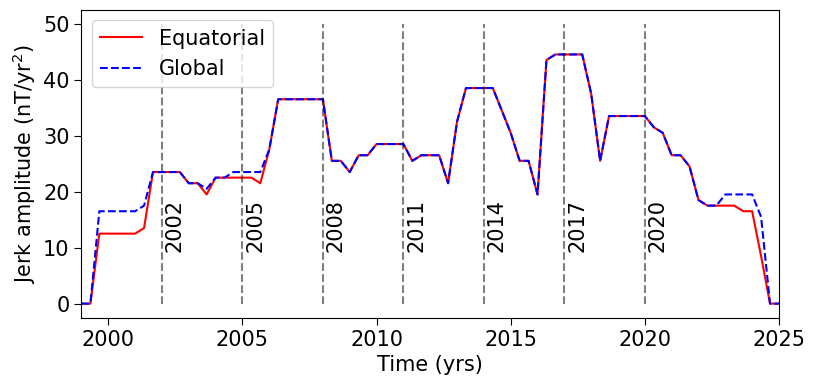

In [26]:
## Plot equatorial jerk amplitude as function of time by max
import numpy as np

time_array = np.linspace(1999,2025,(2025 - 1999)*3+1)
data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) )  #this is the maximum value of jerk amplitude within a time bin, for a specific component, at (theta,phi).

fig,ax = plt.subplots(1,1,figsize=(9,4))


for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<20:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='r',label='Equatorial')


data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]):
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],'--b',label='Global')


from scipy.signal import find_peaks
CHAOS_Z_times, CHAOS_Z_jerks = time_array,data_maxvalue[:]
peaks, props = find_peaks(CHAOS_Z_jerks,distance=6, plateau_size = (None, None)) # 2yr = 6 widths of 4 months apart

approx_jerk_peaks_max_eq = np.zeros( len(peaks))
for i, left_index in enumerate(props['left_edges']):
    right_index = props['right_edges'][i]
    mid = int(np.round( (left_index + right_index)/2.0))  #report the index closest to the middle of the plateau that defines each peak.
    approx_jerk_peaks_max_eq[i] = int(np.round(CHAOS_Z_times[mid]))



ax.set_xlim(1999,2025)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=15)
ax.set_xlabel('Time (yrs)', fontsize=15)
#ax.set_xticks([2000,2010,2020])
#ax.set_xticks([2005,2015,2025],minor=True)
ax.tick_params(axis='both', which='major', labelsize=15, length=5)


ax.tick_params(axis='both', which='major', labelsize=15, length=5)

jerk_times = np.arange(2002,2021,3)
for jt in jerk_times:
    ax.vlines(jt, 0,50, colors='k',alpha=0.5,linestyles='dashed')
    ax.annotate(str(jt), xy=(jt+0.1,10),rotation=90, fontsize=15)

#ax.set_title(r'$\vert \Delta_Z\vert $', fontsize=15)
ax.legend(fontsize=15)
fig.savefig('fig_eq_jerk_max.pdf', bbox_inches='tight')





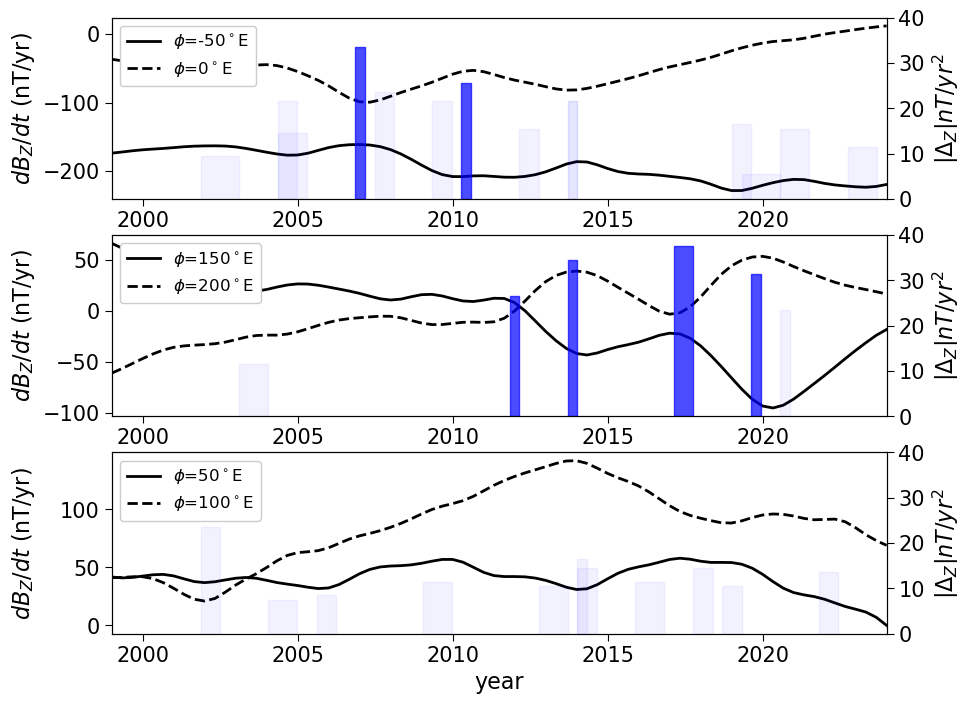

In [27]:
fig, ax = plt.subplots( 3,1,  sharex='row',figsize=(10,8))   

radius = 6371.
time_CHAOS = np.arange(1999,2024.1,1/3.0)
mjd = cp.data_utils.dyear_to_mjd(time_CHAOS, leap_year=False)

for index,(phi_loc1, phi_loc2) in enumerate([[-50,0],[150, 200],[50,100]]):

    dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=13, deriv=1)
    SV_plot = -dBr  #Z-component
    lab = r'$\phi$=' + str(phi_loc1) + r'$^\circ$E'
    ax[index].plot(time_CHAOS,SV_plot, color='black', linewidth=2, label=lab )

    
    dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc2, nmax=13, deriv=1)
    SV_plot = -dBr  #Z-component
    lab = r'$\phi$=' + str(phi_loc2) + r'$^\circ$E'
    ax[index].plot(time_CHAOS,SV_plot, color='black', linestyle='--', linewidth=2, label=lab )
    twinax = ax[index].twinx()

     # plot jerks
    for i in range(len(results_CHAOS82)):
        if results_CHAOS82[i][0] == 90.0 and (
        results_CHAOS82[i][1] == phi_loc1 or results_CHAOS82[i][1] == phi_loc2):
            jerk = results_CHAOS82[i]
            offset = 11
    
            ymin = 0
            ymax = 30
            for event in jerk[offset]:
                if abs(event[1]) > jerk_threshold[2]:
                    #twinax.vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                    twinax.fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.7, color='blue')
                else:
                    #twinax.vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                    twinax.fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.05, color='blue')
    twinax.set_ylim([0,40])
    ax[index].set_xlim([1999,2024])

    ax[index].tick_params(axis='both', which='major', labelsize=15, length=5)
    twinax.tick_params(axis='both', which='major', labelsize=15, length=5)
    twinax.set_ylabel(r'$|\Delta_Z| nT/yr^2$',fontsize=16)
    ax[index].set_xlabel('year',fontsize=16)
    ax[index].set_ylabel(r'$dB_Z/dt$ (nT/yr)',fontsize=16)
    ax[index].legend(loc='upper left',facecolor='white',framealpha=1,fontsize=12)
    
fig.align_ylabels(ax[:])
plt.savefig('SV_comparison.pdf', bbox_inches='tight')

<>:78: SyntaxWarning: invalid escape sequence '\c'
<>:78: SyntaxWarning: invalid escape sequence '\c'
/var/folders/c8/0lxh07f56ds0wttzd4_fnrmh0000gr/T/ipykernel_32685/4117265186.py:78: SyntaxWarning: invalid escape sequence '\c'
  twinax.set_ylabel('Angular change ($^\circ$/yr)', fontsize=15)


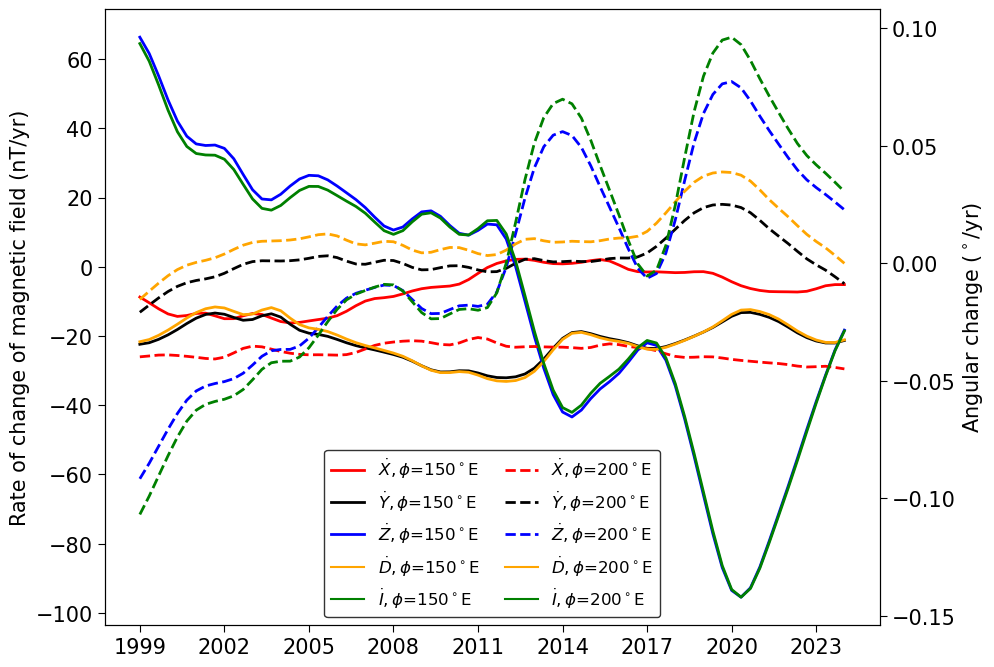

In [28]:
# plot to show pairwise emergence in SV but also D and I.

fig, ax = plt.subplots( 1,1,  sharex='row',figsize=(10,8))   

radius = 6371.
time_CHAOS = np.arange(1999,2024.1,1/3.0)
mjd = cp.data_utils.dyear_to_mjd(time_CHAOS, leap_year=False)

phi_loc1, phi_loc2 = 150, 200

Br, Bt, Bp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=13, deriv=0)
dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=13, deriv=1)

Xdot = -dBt
Ydot = dBp
X = -Bt
Y = Bp
Z = -Br
Zdot = -dBr
D = np.arctan(Y/X) * 180.0/np.pi
Ddot = 1. / (1. + (Y/X)**2 ) * (Ydot * X - Xdot * Y)/X**2 * 180.0/np.pi
I = np.arctan(Z/X) * 180.0/np.pi
Idot = 1. / (1. + (Z/X)**2 ) * (Zdot * X - Xdot * Z)/X**2 * 180.0/np.pi

lab = r'$\dot{X}, \phi$=' + str(phi_loc1) + r'$^\circ$E'
ax.plot(time_CHAOS,Xdot, color='r', linewidth=2, label=lab )

lab = r'$\dot{Y}, \phi$=' + str(phi_loc1) + r'$^\circ$E'
ax.plot(time_CHAOS,Ydot, color='k', linewidth=2, label=lab )

lab = r'$\dot{Z}, \phi$=' + str(phi_loc1) + r'$^\circ$E'
ax.plot(time_CHAOS,Zdot, color='b', linewidth=2, label=lab )

twinax = ax.twinx()

lab = r'$\dot{D}, \phi$=' + str(phi_loc1) + r'$^\circ$E'
twinax.plot(time_CHAOS,Ddot, color='orange', linewidth=2, label=lab )
ax.plot([], [], '', color='orange', label = lab)

lab = r'$\dot{I}, \phi$=' + str(phi_loc1) + r'$^\circ$E'
twinax.plot(time_CHAOS,Idot, color='green', linewidth=2, label=lab )
ax.plot([], [], '', color='green', label = lab)


# !!!!

Br, Bt, Bp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc2, nmax=13, deriv=0)
dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc2, nmax=13, deriv=1)

Xdot = -dBt
Ydot = dBp
X = -Bt
Y = Bp
Z = -Br
Zdot = -dBr
D = np.arctan(Y/X) * 180.0/np.pi
Ddot = 1. / (1. + (Y/X)**2 ) * (Ydot * X - Xdot * Y)/X**2 * 180.0/np.pi
I = np.arctan(Z/X) * 180.0/np.pi
Idot = 1. / (1. + (Z/X)**2 ) * (Zdot * X - Xdot * Z)/X**2 * 180.0/np.pi

lab = r'$\dot{X}, \phi$=' + str(phi_loc2) + r'$^\circ$E'
ax.plot(time_CHAOS,Xdot, '--r', linewidth=2, label=lab )

lab = r'$\dot{Y}, \phi$=' + str(phi_loc2) + r'$^\circ$E'
ax.plot(time_CHAOS,Ydot, '--k', linewidth=2, label=lab )

lab = r'$\dot{Z}, \phi$=' + str(phi_loc2) + r'$^\circ$E'
ax.plot(time_CHAOS,Zdot, '--b', linewidth=2, label=lab )

lab = r'$\dot{D}, \phi$=' + str(phi_loc2) + r'$^\circ$E'
twinax.plot(time_CHAOS,Ddot, color='orange', linestyle='dashed', linewidth=2, label=lab )
ax.plot([], [], '', color='orange', label = lab)

lab = r'$\dot{I}, \phi$=' + str(phi_loc2) + r'$^\circ$E'
twinax.plot(time_CHAOS,Idot, color='green', linestyle='dashed', linewidth=2, label=lab )
ax.plot([], [], '', color='green', label = lab)

twinax.set_ylabel('Angular change ($^\circ$/yr)', fontsize=15)
ax.set_ylabel('Rate of change of magnetic field (nT/yr)', fontsize=15)
ax.legend(
    ncol=2, 
    loc='lower center', 
    fontsize=12, 
    frameon=True, 
    edgecolor='black', 
    facecolor='white',
    columnspacing=1.5
)

ax.set_xticks(np.arange(1999,2024,3))
ax.tick_params(axis='both', which='major', labelsize=15, length=5)
twinax.tick_params(axis='both', which='major', labelsize=15, length=5)
plt.savefig('SV_grand_comparison.pdf', bbox_inches='tight')

In [29]:
filename = dir+"/Jerks_CHAOS82_l5_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82_l5 = pickle.load(fp)

filename = dir+"/Jerks_CHAOS82_l4_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82_l4 = pickle.load(fp)


filename = dir+"/Jerks_CHAOS82_l3_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82_l3 = pickle.load(fp)

filename = dir+"/Jerks_CHAOS82_l2_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82_l2 = pickle.load(fp)

filename = dir+"/Jerks_CHAOS82_l1_abserror_3_5x5_{0:1d}M.results".format(Nsample)
with open(filename, "rb") as fp:   # Unpickling
# get metadata first
    [SV_error, K_MIN, K_MAX, THIN, burn_in, NSAMPLE, sigmas, thetas, phis] = pickle.load(fp)
# get results
    results_CHAOS82_l1 = pickle.load(fp)

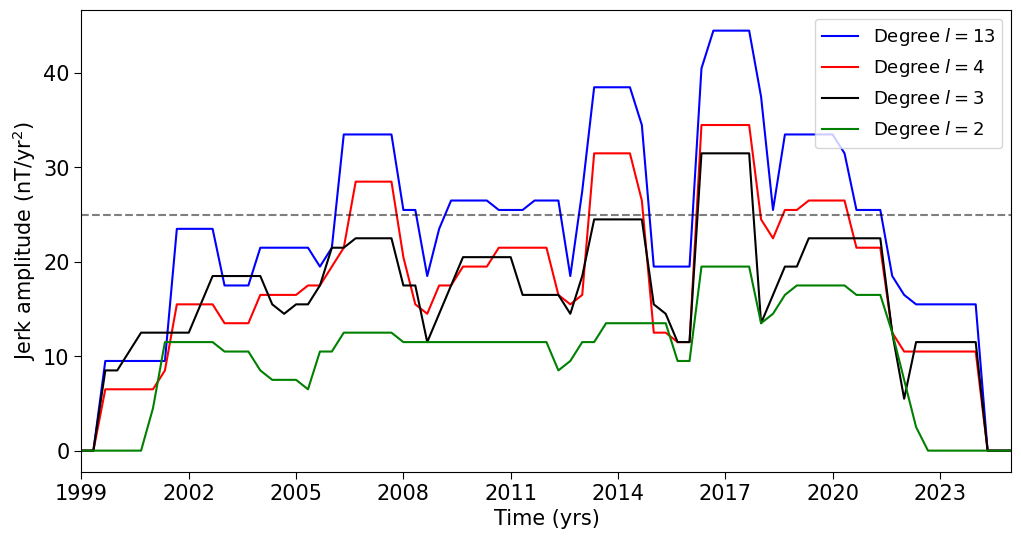

In [30]:
# compare different resolutions

## Plot equatorial jerk amplitude as function of time by max
import numpy as np

dist_from_eq = 0.1

time_array = np.linspace(1999,2025,(2025 - 1999)*3+1)
data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) )  #this is the maximum value of jerk amplitude within a time bin, for a specific component, at (theta,phi).

fig,ax = plt.subplots(1,1,figsize=(12,6))


for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<dist_from_eq:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='b',label='Degree $l=13$')


data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]):
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
#ax.plot(time_array,data_maxvalue[:],'--b',label='Global, $l=13$')

data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82_l4:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<dist_from_eq:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='r',label='Degree $l=4$')

data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82_l3:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<dist_from_eq:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='k',label='Degree $l=3$')

data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82_l2:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<dist_from_eq:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='g',label='Degree $l=2$')

'''data = np.zeros((time_array.shape[0],thetas.shape[0], phis.shape[0]) ) 
for jerk in results_CHAOS82_l1:
    theta = jerk[0]
    phi=jerk[1]
    theta_index, phi_index = abs(thetas-theta).argmin(), abs(phis-phi).argmin()

    for component in [2]:
        if component == 0:
            offset = 3
        elif component == 1: 
            offset = 7
        else:
            offset = 11
        for event in jerk[offset]:
            for itime, time in enumerate(time_array):  
               if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)) and (abs(event[1]) > data[itime,theta_index,phi_index]) and abs(90-theta)<dist_from_eq:
                    data[itime,theta_index,phi_index] = abs(event[1]) 
data_maxvalue = data.max(axis=2).max(axis=1)  #Take max over theta, phi.
ax.plot(time_array,data_maxvalue[:],color='r',label='Equatorial, $l=1$')
'''

ax.set_xlim(1999,2025)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=15)
ax.set_xlabel('Time (yrs)', fontsize=15)
ax.set_xticks(np.arange(1999,2024,3))
#ax.set_xticks([2005,2015,2025],minor=True)
ax.tick_params(axis='both', which='major', labelsize=15, length=5)


ax.tick_params(axis='both', which='major', labelsize=15, length=5)

#jerk_times = np.arange(2002,2025,3)
#for jt in jerk_times:
#    ax.vlines(jt, 0,50, colors='r',alpha=0.4,linestyles='dashed')
#    ax.annotate(str(jt), xy=(jt+0.1,0),rotation=90, fontsize=15)

#ax.set_title(r'$\vert \Delta_Z\vert $', fontsize=15)
ax.legend(fontsize=13,loc='upper right')

ax.hlines(jerk_threshold[2],1999,2025,colors='k',alpha=0.5,linestyles='dashed')
fig.savefig('fig_eq_jerk_max_cmp.pdf', bbox_inches='tight')




    

# Additional figures

<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/var/folders/c8/0lxh07f56ds0wttzd4_fnrmh0000gr/T/ipykernel_32685/1665739966.py:39: SyntaxWarning: invalid escape sequence '\c'
  ax[imodel].set_xlabel('Longitude ($^\circ$)')


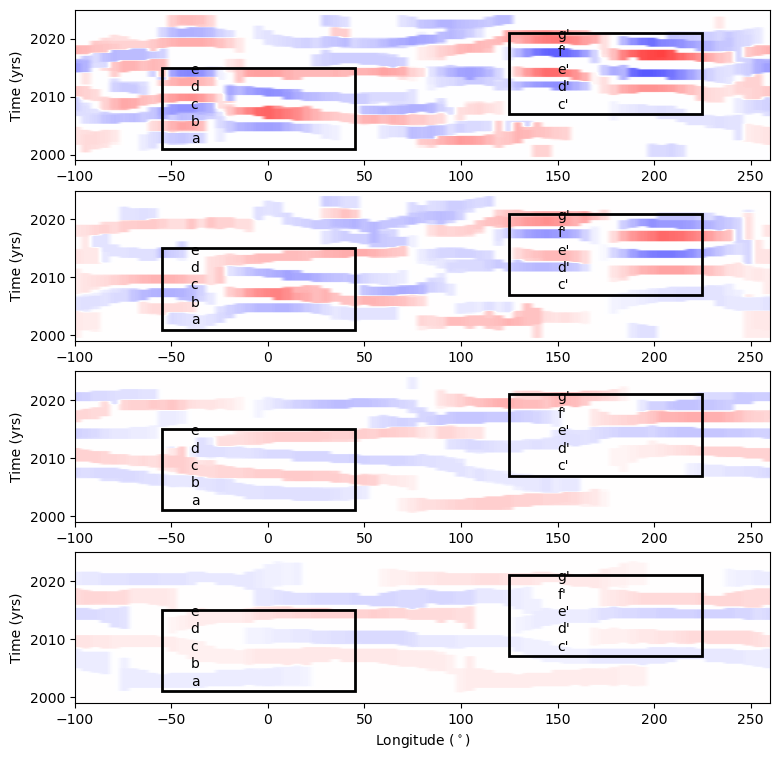

In [31]:
time_array = np.linspace(2025,1999,100)
longitude_array = phis 
component = 2
if component == 0:
    offset = 3
elif component == 1: 
    offset = 7
else:
    offset = 11

    fig,ax = plt.subplots(4, 1, figsize=(9,9) )


for imodel,model in enumerate([results_CHAOS82, results_CHAOS82_l4, results_CHAOS82_l2, results_CHAOS82_l1]):
    data = np.zeros((time_array.shape[0],longitude_array.shape[0]) )
    for jerk in model:
        theta = jerk[0]
        phi=jerk[1]
        if phi < -360:
            phi += 360
        if phi > 360:
            phi -= 360
        index = abs(phis - phi).argmin()
    
        if abs(90-theta) < 10:
            for event in jerk[offset]:
                for itime, time in enumerate(time_array):
                   if not ( (event[3] < time-jerk_tolerance) or (event[2] > time+jerk_tolerance)):
                       if abs(event[1]) > abs(data[itime,index]): 
                           data[itime,index] = event[1]
                       #data[itime,index] = time

    extended_long = np.concatenate([phis[36:]-360,phis,phis[:37]+360])
    extended_data = np.concatenate([data[:,36:],data, data[:,:37]],axis=1)
    ax[imodel].imshow(extended_data, extent = (extended_long.min(), extended_long.max(), time_array.min(), time_array.max() ), cmap='bwr', aspect=3,vmin=-60,vmax=60)
    #fig.colorbar(shrink = 0.8, label='Jerk amplitude nT$/yr^2$')
    
    ax[imodel].set_xlim(-100, 260)
    ax[imodel].set_xlabel('Longitude ($^\circ$)')
    ax[imodel].set_ylabel('Time (yrs)')
    import matplotlib.patches as patches
    rect = patches.Rectangle((-55, 2001), 100, 14, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax[imodel].add_patch(rect)
    rect = patches.Rectangle((125, 2007), 100, 14, linewidth=2, edgecolor='k', facecolor='none')
    # Add the patch to the Axes
    ax[imodel].add_patch(rect)

    ax[imodel].annotate('e',xy=(-40,2014),color='k')
    ax[imodel].annotate('d',xy=(-40,2011),color='k')
    ax[imodel].annotate('c',xy=(-40,2008),color='k')
    ax[imodel].annotate('b',xy=(-40,2005),color='k')
    ax[imodel].annotate('a',xy=(-40,2002),color='k')

    ax[imodel].annotate("c'",xy=(150,2008))
    ax[imodel].annotate("d'",xy=(150,2011))
    ax[imodel].annotate("e'",xy=(150,2014))
    ax[imodel].annotate("f'",xy=(150,2017))
    ax[imodel].annotate("g'",xy=(150,2020))
    
    #fig.savefig('Time_long_threshold{0:d}.pdf'.format(thres),bbox_inches='tight')

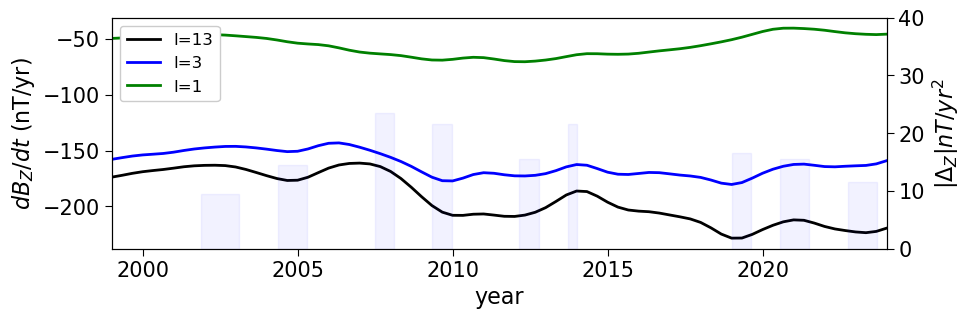

In [32]:
fig, ax = plt.subplots( 1,1,  sharex='row',figsize=(10,3))   

radius = 6371.
time_CHAOS = np.arange(1999,2024.1,1/3.0)
mjd = cp.data_utils.dyear_to_mjd(time_CHAOS, leap_year=False)

phi_loc1 = -50


dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=13, deriv=1)
SV_plot = -dBr  #Z-component
lab = 'l=13'
ax.plot(time_CHAOS,SV_plot, color='black', linewidth=2, label=lab )

dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=3, deriv=1)
SV_plot = -dBr  #Z-component
ax.plot(time_CHAOS,SV_plot, color='blue', linewidth=2, label='l=3' )

dBr, dBt, dBp = model_CHAOS82.synth_values_tdep(mjd, radius, 90.0, phi_loc1, nmax=1, deriv=1)
SV_plot = -dBr  #Z-component
ax.plot(time_CHAOS,SV_plot, color='green', linewidth=2, label='l=1' )


twinax = ax.twinx()

 # plot jerks
for i in range(len(results_CHAOS82_l1)):
    if results_CHAOS82_l1[i][0] == 90.0 and ( results_CHAOS82_l1[i][1] == phi_loc1 ):
        jerk = results_CHAOS82[i]
        offset = 11

        ymin = 0
        ymax = 30
        for event in jerk[offset]:
            if abs(event[1]) > jerk_threshold[2]:
                #twinax.vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                twinax.fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.7, color='blue')
            else:
                #twinax.vlines(event[0], ymin, abs(event[1]), colors='k',linestyles='dashed')
                twinax.fill_betweenx([ymin, abs(event[1])], event[2], event[3],alpha=0.05, color='blue')
twinax.set_ylim([0,40])
ax.set_xlim([1999,2024])

ax.tick_params(axis='both', which='major', labelsize=15, length=5)
twinax.tick_params(axis='both', which='major', labelsize=15, length=5)
twinax.set_ylabel(r'$|\Delta_Z| nT/yr^2$',fontsize=16)
ax.set_xlabel('year',fontsize=16)
ax.set_ylabel(r'$dB_Z/dt$ (nT/yr)',fontsize=16)
ax.legend(loc='upper left',facecolor='white',framealpha=1,fontsize=12)

